In [1]:
# Required packages:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import sklearn.feature_selection

from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_curve, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import SGDClassifier

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

import random as python_random
import os

In [2]:
# Loading data:
def load_data(file):
    df = pd.read_csv(file)
    return df

data = load_data("Transactions.csv")
data

,Transaction,Customer_Type,SystemF1,SystemF2,SystemF3,SystemF4,SystemF5,Account_Page,Account_Page_Time,Info_Page,...,ProductPage_Time,Month,Weekday,SpecificHoliday,GoogleAnalytics_BR,GoogleAnalytics_ER,GoogleAnalytics_PV,Ad_Campaign_1,Ad_Campaign2,Ad_Campaign3
0,0,Returning_Customer,1,2,7,10,2,0,0.000000,0,...,0.000000,11,True,0.0,0.200000,0.200000,0.000000,0,0,0
1,0,Returning_Customer,2,2,3,2,3,10,147.458333,4,...,1587.765598,12,True,0.0,0.000000,0.010046,0.000000,0,0,0
2,0,New_Customer,2,2,1,2,1,0,0.000000,0,...,183.500000,12,True,0.0,0.000000,0.033333,0.000000,0,0,0
3,0,Returning_Customer,2,2,2,6,1,0,0.000000,0,...,295.000000,4,True,0.8,0.011765,0.052941,0.000000,0,0,0
4,0,Returning_Customer,2,2,4,10,3,0,0.000000,2,...,624.000000,3,True,0.0,0.015385,0.046154,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12200,1,New_Customer,1,1,6,5,5,4,68.666667,0,...,617.150000,9,True,0.0,0.000000,0.004444,9.253162,0,0,0
12201,1,Returning_Customer,3,2,1,10,3,7,86.277778,2,...,2170.286706,11,False,0.0,0.003571,0.021528,25.765986,0,0,0
12202,0,Returning_Customer,3,2,1,7,2,0,0.000000,0,...,51.000000,4,False,0.0,0.000000,0.050000,0.000000,0,0,0
12203,0,New_Customer,2,2,6,5,4,4,102.200000,0,...,72.000000,7,True,0.0,0.000000,0.016667,0.000000,0,0,0


In [3]:
# Setting seed:
seed_value = 0
np.random.seed(seed_value)
python_random.seed(seed_value)
tf.random.set_seed(seed_value)
import os
os.environ["PYTHONHASHSEED"] = str(seed_value)

In [4]:
# Percentage of transactions that belongs to the positive class:
def data_distribution(df, target): 
    negative = len (df[df[target] ==0]) / len(df) * 100
    positive = len(df[df[target] ==1]) / len(df) * 100
    print("positive class: {} %".format(round(positive,2)))
    print("negative class: {} %".format(round(negative,2)))

data_distribution(data, "Transaction")   

positive class: 15.63 %
negative class: 84.37 %


In [5]:
# Encoding variables:
def encode_strings(df, variable):
    dummies = pd.get_dummies(df[variable])
    new_data = pd.concat([df, dummies], axis = 1)
    new_data = new_data.drop([variable], axis = 1)
    return new_data

data = encode_strings(data, "Customer_Type")

def encode_boolean(df, variable):
    df[variable].replace({False: 0, True: 1}, inplace = True)
    return df

data = encode_boolean(data, "Weekday")

In [6]:
# Splitting data train/test:
def split_data(df):
    train, test = train_test_split(df, test_size = 0.2, random_state = 101)
    train.reset_index(drop = True, inplace = True)
    test.reset_index(drop = True, inplace = True)
    return train, test

train, test = split_data(data)

In [7]:
# Splitting variables:
def split_variables(df, target):
    X = df.drop(target, axis=1)
    y = df[target]
    return X, y

X_train, y_train = split_variables(train, "Transaction")

In [8]:
# Scaling variables:
def data_scaler(df):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

X_train = data_scaler(X_train)

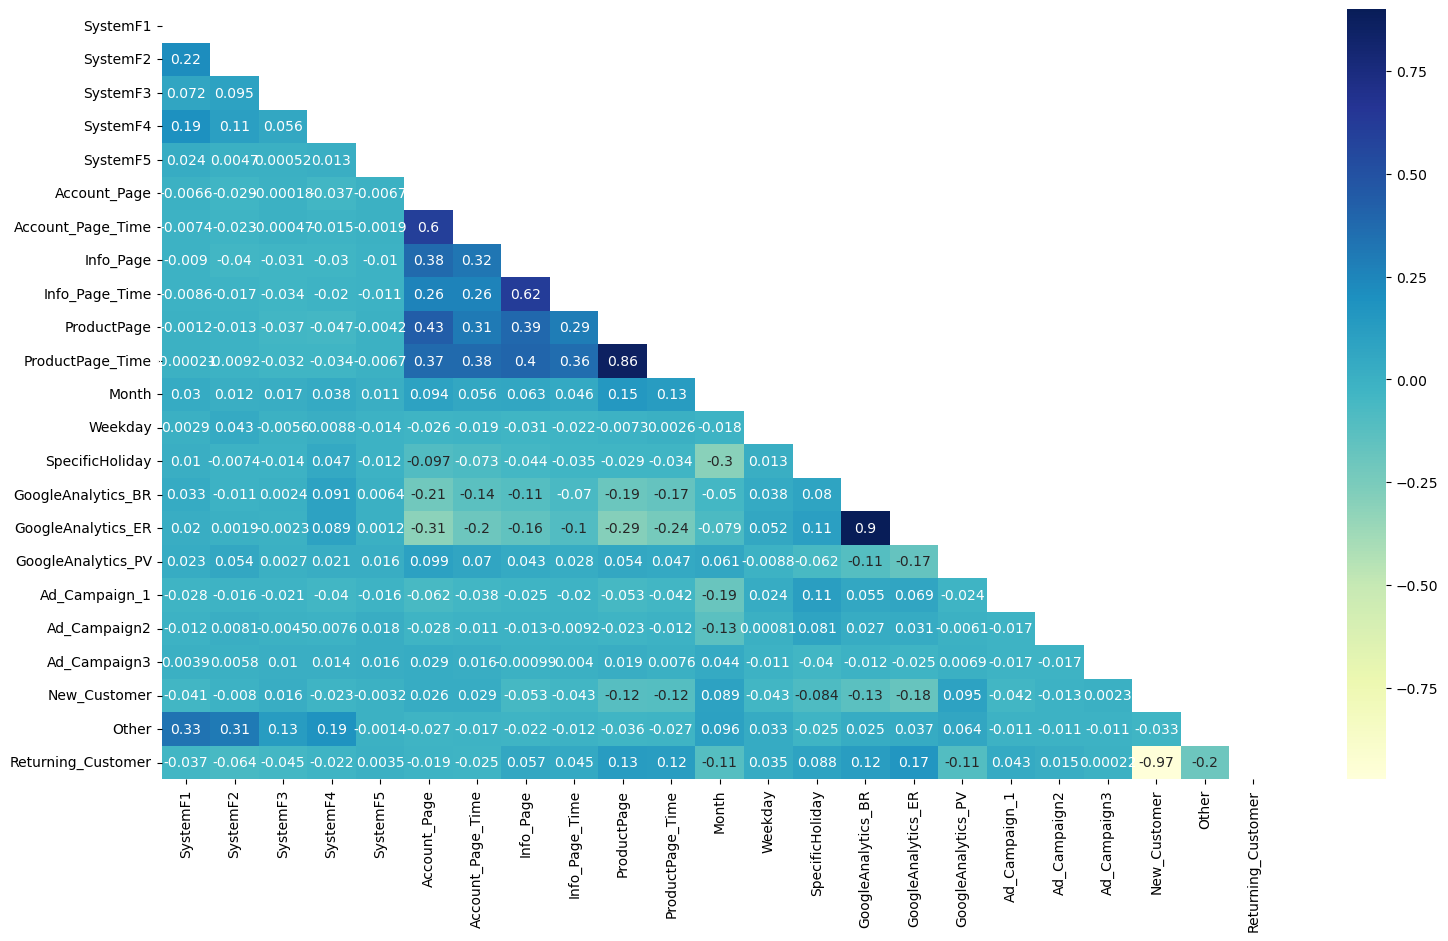

Ad_Campaign_1 0.0
Ad_Campaign3 0.0005147793852155984
Ad_Campaign2 0.0006383672931741054
Other 0.0006863725136207979
SpecificHoliday 0.0012612094937782161
Returning_Customer 0.002798660572576002
New_Customer 0.00478017659521309
Weekday 0.006780537243476599
Info_Page 0.012893320527799967
SystemF1 0.013782719606717824
SystemF2 0.016272227329258752
SystemF4 0.019003707556733047
Info_Page_Time 0.021063636594040123
SystemF5 0.024724074247157852
SystemF3 0.02580881262080976
Account_Page 0.0390852851692606
Month 0.04203484224154241
Account_Page_Time 0.05385128879409258
ProductPage 0.06611041662394691
GoogleAnalytics_ER 0.07024633670077463
ProductPage_Time 0.07335802276140868
GoogleAnalytics_BR 0.07652290119743138
GoogleAnalytics_PV 0.427782304931971


In [9]:
# Feature selection:

# Correlation matrix:
def correlation_matrix(df):
    plt.rcParams["figure.figsize"] = (18,10)
    mask = np.triu(np.ones_like(df.corr()))
    dataplot = sns.heatmap(df.corr(), cmap = "YlGnBu", annot = True, mask = mask)
    return plt.show()

correlation_matrix(X_train)

# Decision tree with gini:
def decision_trees(df, target):
    tree = DecisionTreeClassifier(random_state = 0).fit(df, target)
    for importance, features in sorted(zip(tree.feature_importances_, df.columns), reverse = False)[:]:
        print(features, importance)

decision_trees(X_train, y_train)

# Dropping features:
def dropping(df, variable):
    df = df.drop(variable, axis = 1)
    return df

X_train = dropping(X_train, ["GoogleAnalytics_BR", "ProductPage_Time", "Info_Page", "Account_Page_Time", "Ad_Campaign_1", "Other", "Ad_Campaign2", "SpecificHoliday", "Returning_Customer", "New_Customer", "Ad_Campaign3", "Weekday"])

In [10]:
# Model 1: K-Nearest Neighbors (baseline model): https://www.kaggle.com/code/arunimsamudra/k-nn-with-hyperparameter-tuning
grid_params = {"n_neighbors": list(range(0, 30, 2)),
               "weights": ["uniform", "distance"],
               "metric": ["minkowski", "euclidean", "manhattan"]}

def knn_tuning(grid, X_train, y_train):
    cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 101)
    grid = RandomizedSearchCV(KNeighborsClassifier(), n_iter = 10, param_distributions = grid, cv = cv_outer, verbose = 0, scoring = "f1")
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    best_score = grid.best_score_
    return best_model, best_params, best_score

best_model_knn, best_params_knn, best_score_knn = knn_tuning(grid_params, X_train.values, y_train)

In [11]:
# Calculate the class weights: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data / https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
def weight (df, target): 
    negative_class, positive_class = np.bincount(df[target])
    total = negative_class + positive_class
    weight_positive_class = (1 / positive_class) * (total / 2)
    weight_negative_class = (1 / negative_class) * (total / 2)
    class_weight ={0: weight_negative_class, 1: weight_positive_class}
    return class_weight

class_weight = weight(train , "Transaction")

In [12]:
# Model 2: Logistic Regression (using weights, unbalanced data)
param_grid = {"loss": ["log"],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "learning_rate": ["constant", "optimal", "invscaling"],
    "eta0":[0.01, 0.1, 1.0]}

def logisticRegression(grid, X_train, y_train):
    model = SGDClassifier(class_weight=class_weight)
    cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 101)
    grid = RandomizedSearchCV(estimator = model, param_distributions = grid, cv = cv, scoring = "f1", n_iter = 10, random_state = 101)
    r = grid.fit(X_train, y_train)
    best_model = r.best_estimator_
    best_params = r.best_params_
    best_score = r.best_score_
    return best_model, best_params, best_score, r

best_model_lr, best_params_lr, best_score_lr, r = logisticRegression(param_grid, X_train.values, y_train.values)

In [13]:
# Calculate the F1 score https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [14]:
# Model 3: Neural Network: https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/
def neuralNetwork(hidden_1, hidden_2, learning_rate, dropout, metrics = f1, input_dim = X_train.shape[-1]): 
    model = Sequential()
    model.add(Dense(hidden_1, input_dim = input_dim, activation = "relu", kernel_initializer = "normal"))
    model.add (Dropout(dropout))
    model.add(Dense(hidden_2, activation = "relu", kernel_initializer = "normal")) 
    model.add(Dense(units = 1, activation = "sigmoid"))
    model.compile(loss = "binary_crossentropy", optimizer= "Adam", metrics = f1)
    return model

# Dictionary that can be used stored parameters that can be tuned:
param_grid = dict(hidden_1 = [5,10, 15, 20, 25, 30],
                  hidden_2 = [5,10,15, 20, 25, 30],
                  learning_rate = np.linspace(0.1, 1),
                  dropout = np.linspace(0, 0.1),
                  batch_size = list(range(180, 400, 1)),
                  epochs = [40, 60, 80, 100, 120] )

# Grid search the best parameters:
def grid_search_NN (X_train, y_train, model, paramGrid, class_weight): 
    model = KerasClassifier(build_fn = model, verbose = 0)
    cv= StratifiedKFold(n_splits = 10, shuffle = True, random_state = 101)
    grid = RandomizedSearchCV(estimator = model, n_iter = 1, n_jobs = 1, cv = cv,
                              param_distributions = paramGrid, scoring = "f1")
    training_validation_result = grid.fit(X_train, y_train, class_weight = class_weight)
    best_model = training_validation_result.best_estimator_
    best_params = training_validation_result.best_params_
    best_score = training_validation_result.best_score_
    return best_model, best_params, best_score, training_validation_result

best_model_NN, best_params_NN, best_score_NN, result = (grid_search_NN(X_train, y_train, neuralNetwork,param_grid, class_weight = class_weight))

31/31 [==============================] - 0s 650us/step


In [15]:
# Preprocessing test data; split + scale test so that it has the same 
X_test, y_test = split_variables(test, "Transaction")
X_test = data_scaler(X_test)
X_test = dropping(X_test, ["GoogleAnalytics_BR", "ProductPage_Time", "Info_Page", "Account_Page_Time", "Ad_Campaign_1", "Other", "Ad_Campaign2", "SpecificHoliday", "Returning_Customer", "New_Customer", "Ad_Campaign3", "Weekday"])

# Predictions:
KNN_predictions = best_model_knn.predict(X_test)
NN_predictions = best_model_NN.predict(X_test)
LR_predictions = best_model_lr.predict(X_test)

# Convert predictions and ground truth csv:
def predictions_csv(y_test, KNN_predictions, LR_predictions, NN_predictions): 
    # Preprocessing ground truth data
    Ground_truth = pd.DataFrame(y_test)
    Ground_truth.index = Ground_truth.index
    Ground_truth.columns = ["Ground truth"]
    # Preprocessing knn predictions
    knn = pd.DataFrame(KNN_predictions)
    knn.index = knn.index 
    knn.columns = ["KNN_predictions"]
    # Preprocessing Logistic Regression predictions
    LR = pd.DataFrame(LR_predictions)
    LR.index = LR.index 
    LR.columns = ["LR_predictions"]
    # Preprocessing Neural Network predictions
    NN = pd.DataFrame(NN_predictions)
    NN.index = NN.index 
    NN.columns = ["NN_predictions"]
    # Combine all them
    result = pd.concat([Ground_truth,knn, LR, NN], axis = 1, join = "inner")
    result.to_csv("Predictions.csv")

predictions_csv(y_test, KNN_predictions, LR_predictions, NN_predictions)

77/77 [==============================] - 0s 645us/step


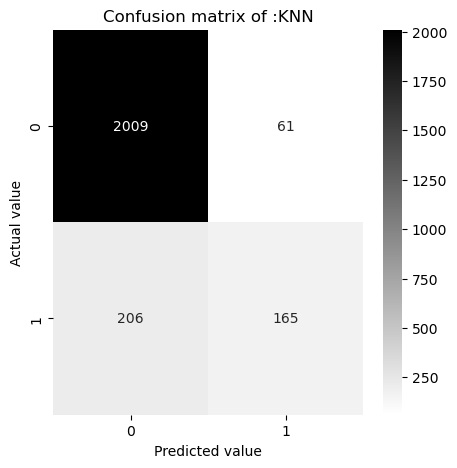

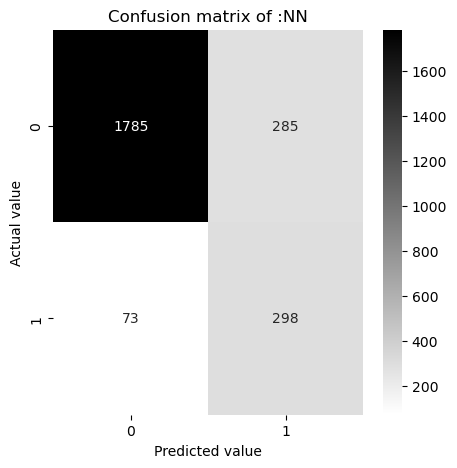

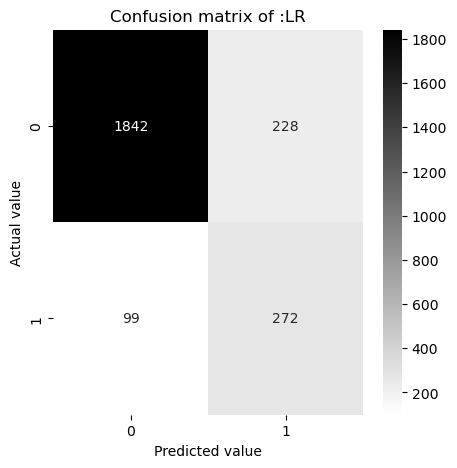

In [16]:
# Plot the confusion matrix: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
def plot_confusion_matrix(y_test, y_predictions, model_name): 
    matrix = confusion_matrix(y_test, y_predictions)
    plt.figure(figsize = (5,5))
    sns.heatmap(matrix, annot = True, fmt="d", cmap = "binary")
    plt.title("Confusion matrix of :" + model_name)
    plt.ylabel("Actual value")
    plt.xlabel("Predicted value")

plot_confusion_matrix(y_test, KNN_predictions, "KNN")
plot_confusion_matrix(y_test, NN_predictions, "NN")
plot_confusion_matrix(y_test, LR_predictions, "LR")

In [17]:
# Calculating F1, precision and recall:
def performance_report(y_test, y_predicions): 
    f1 = f1_score(y_test, y_predicions)
    precision = precision_score(y_test, y_predicions)
    recall = recall_score(y_test, y_predicions)
    return precision, recall, f1

precision_knn, recall_knn, f1_knn = performance_report(y_test, KNN_predictions)
precision_lr, recall_lr, f1_lr = performance_report(y_test, LR_predictions)
precision_nn, recall_nn, f1_nn = performance_report(y_test, NN_predictions)

print(precision_knn, recall_knn, f1_knn)
print(precision_lr, recall_lr, f1_lr)
print(precision_nn, recall_nn, f1_nn)

0.7300884955752213 0.444743935309973 0.5527638190954773
0.544 0.7331536388140162 0.624569460390356
0.5111492281303602 0.8032345013477089 0.6247379454926625
